
# **Project Overview**

This project focuses on converting images into music and enhancing image resolution using advanced techniques. The steps involved include reading and processing images, splitting RGB channels, generating music notes from image pixels, and upscaling images using the LAPSRN model.

## Key Components:
- **Image Processing**: Reading, displaying, and splitting images into RGB channels.
- **Music Generation**: Creating music notes from image pixels and writing them to MIDI files.
- **Super-Resolution**: Upscaling images using the LAPSRN model and bicubic interpolation.

**Reference**:
- [TF-LapSRN GitHub Repository](https://github.com/fannymonori/TF-LapSRN)

---

# **Proje Özeti**

Bu proje, görüntüleri müziğe dönüştürme ve görüntü çözünürlüğünü gelişmiş teknikler kullanarak artırma üzerine odaklanmaktadır. Projede yer alan adımlar arasında görüntülerin okunması ve işlenmesi, RGB kanallarına ayrılması, görüntü piksellerinden müzik notaları oluşturulması ve LAPSRN modeli kullanılarak görüntülerin ölçeklendirilmesi bulunmaktadır.

## Ana Bileşenler:
- **Görüntü İşleme**: Görüntüleri okuma, gösterme ve RGB kanallarına ayırma.
- **Müzik Oluşturma**: Görüntü piksellerinden müzik notaları oluşturma ve bunları MIDI dosyalarına yazma.
- **Süper-Çözünürlük**: LAPSRN modeli ve bikübik enterpolasyon kullanarak görüntüleri ölçeklendirme.

**Referans**:
- [TF-LapSRN GitHub Deposu](https://github.com/fannymonori/TF-LapSRN)



# **Importing Libraries**

In this section, we import all the necessary libraries required for our image processing and super-resolution tasks. 
These include libraries for file operations, threading, image processing, and visualization.

**Kütüphanelerin İçe Aktarılması**

Bu bölümde, görüntü işleme ve süper çözünürlük görevlerimiz için gerekli tüm kütüphaneleri içe aktarıyoruz. 
Bunlar arasında dosya işlemleri, iş parçacığı yönetimi, görüntü işleme ve görselleştirme için kütüphaneler bulunmaktadır.

- `os`: For file and directory operations. / Dosya ve dizin işlemleri için.
- `threading` and `concurrent.futures.ThreadPoolExecutor`: For managing multi-threading. / Çoklu iş parçacığını yönetmek için.
- `time`: For measuring execution time. / Çalışma süresini ölçmek için.
- `cv2`: OpenCV library for image processing. / Görüntü işleme için OpenCV kütüphanesi.
- `dnn_superres`: Super resolution module of OpenCV. / OpenCV'nin süper çözünürlük modülü.
- `numpy`: For numerical operations. / Sayısal işlemler için.
- `PIL.Image`: For image processing. / Görüntü işleme için.
- `music21`: For music data manipulation. / Müzik verilerini işlemek için.
- `matplotlib`: For plotting and visualization. / Çizim ve görselleştirme için.


In [1]:
import os  # Dosya ve dizin işlemleri için / For file and directory operations
import threading  # Çoklu iş parçacığı için / For multi-threading
from concurrent.futures import ThreadPoolExecutor  # İş parçacığı havuzu yönetimi için / For managing a pool of threads
import time  # Zaman ölçümleri için / For timing measurements
import cv2  # OpenCV, görüntü işleme için / For image processing
from cv2 import dnn_superres  # OpenCV süper çözünürlük modülü / Super resolution module of OpenCV
import numpy as np  # Sayısal işlemler için / For numerical operations
from PIL import Image  # Görüntü işleme için / For image processing
from music21 import stream, note, converter  # Müzik verileri için / For music data
import matplotlib_inline as mpl  # Matplotlib için / For Matplotlib
import matplotlib.pyplot as plt  # Grafik çizimi için / For plotting graphs


# **Creating and Checking File Paths**

Here, we define the function `generate_file_path` to create necessary directories if they don't already exist. 
We also specify the paths we will use to store images, their RGB channels, and the output results.

**Dosya Yollarının Oluşturulması ve Kontrolü**

Burada, gerekli dizinleri yoksa oluşturmak için `generate_file_path` fonksiyonunu tanımlıyoruz. 
Ayrıca, görüntüleri, RGB kanallarını ve çıktı sonuçlarını depolamak için kullanacağımız yolları belirtiyoruz.

- `generate_file_path(file_path)`: Checks if a path exists, creates it if it doesn't. / Bir yolun var olup olmadığını kontrol eder, yoksa oluşturur.
- We define paths for storing images, their RGB channels, and processed outputs. / Görüntüleri, RGB kanallarını ve işlenmiş çıktıları depolamak için yollar tanımlıyoruz.


In [2]:
def generate_file_path(file_path):
    """
    Belirtilen dosya yolunu oluşturur. 
    Eğer dosya yolu zaten mevcutsa, bu durumu bildirir.
    
    Creates the specified file path.
    If the path already exists, notifies the user.
    """
    if not os.path.exists(file_path):
        os.makedirs(file_path)
        print(f"{file_path} oluşturuldu.") # File path created
    else:
        print(f"{file_path} zaten mevcut.") # File path already exists

In [3]:
# Kullanılacak dosya yolları / File paths to be used
image_get_path = "images/"
# Resimlerin alınacağı ana dizin / Main directory where the images are stored

image_output_path = "output/"
# İşlenen resimlerin kaydedileceği dizin / Directory where the processed images will be saved

image_upscale_path = "upscale/"
# Ölçeklendirilmiş resimlerin kaydedileceği dizin / Directory where the upscaled images will be saved

image_RGB_path = "RGB/"
# RGB kanal resimlerinin kaydedileceği ana dizin / Main directory for storing RGB channel images

image_RGB_R_path = "RGB/R/"
# Kırmızı kanal resimlerinin kaydedileceği dizin / Directory where the images of the red channel will be stored

image_RGB_G_path = "RGB/G/"
# Yeşil kanal resimlerinin kaydedileceği dizin / Directory where the images of the green channel will be stored

image_RGB_B_path = "RGB/B/"

# Dosya yollarının listesi / List of file paths
paths = [
    image_get_path, image_RGB_path, image_RGB_R_path, 
    image_RGB_G_path, image_RGB_B_path, image_output_path, 
    image_upscale_path
]

# Dosya yollarını oluştur / Create the file paths
for path in paths:
    generate_file_path(path)
# Her bir yolun var olup olmadığını kontrol eder ve yoksa oluşturur / 
# Checks if each path exists and creates it if it does not

images/ zaten mevcut.
RGB/ zaten mevcut.
RGB/R/ zaten mevcut.
RGB/G/ zaten mevcut.
RGB/B/ zaten mevcut.
output/ zaten mevcut.
upscale/ zaten mevcut.


# **Setting Up Image Parameters**

In this section, we define the parameters for the image we will process. We specify the file path and pixel count settings based on the resolution of the image.

## Explanation:

- **img_name**: The name of the image to be processed. In this case, it is set to `"plague.png"`.
- **image_path**: This variable constructs the full file path for the image using the base path (`image_get_path`) and the image name (`img_name`).

### Pixel Count Settings:
We have several options for setting the pixel count based on the image resolution:

- **pixelCount = 4000**: This is commented out and can be used for testing with a low pixel count.
- **pixelCount = 230400**: Commented out for a lower pixel count, suitable for a 480x480 image which takes approximately 10 minutes.
- **pixelCount = 1050000**: This is the active setting, suitable for a 1024x1024 image which takes approximately 1 hour.
- **pixelCount = 17000000**: Commented out for a high-resolution image, suitable for a 4096x4096 image which takes approximately 12 hours.

### Notes Processing:
- **notaCount = 2000**: Specifies the number of notes to process in each step.

---

# **Görüntü Parametrelerinin Ayarlanması**

Bu bölümde, işleyeceğimiz resim için parametreleri tanımlıyoruz. Dosya yolunu ve resmin çözünürlüğüne bağlı olarak piksel sayısı ayarlarını belirtiyoruz.

## Açıklama:

- **img_name**: İşlenecek resmin adı. Bu durumda `"plague.png"` olarak ayarlanmıştır.
- **image_path**: Bu değişken, temel yol (`image_get_path`) ve resim adı (`img_name`) kullanılarak resmin tam dosya yolunu oluşturur.

### Piksel Sayısı Ayarları:
Resim çözünürlüğüne bağlı olarak piksel sayısını ayarlamak için birkaç seçeneğimiz var:

- **pixelCount = 4000**: Bu, düşük piksel sayısıyla test yapmak için yorum satırına alınmıştır.
- **pixelCount = 230400**: Yorum satırına alınmış, 480x480 boyutundaki bir resim için uygun, yaklaşık 10 dakika sürer.
- **pixelCount = 1050000**: Bu, aktif ayar olup, 1024x1024 boyutundaki bir resim için uygundur ve yaklaşık 1 saat sürer.
- **pixelCount = 17000000**: Yorum satırına alınmış, yüksek çözünürlüklü bir resim için uygundur ve 4096x4096 boyutundaki bir resim için yaklaşık 12 saat sürer.

### Notaların İşlenmesi:
- **notaCount = 2000**: Her adımda işlenecek nota sayısını belirtir.


In [4]:
img_name = "plague.png" 
# İşlenecek resmin adı / Name of the image to be processed

image_path = os.path.join(image_get_path, img_name)
# Resmin dosya yolunu oluştur / Create the file path for the image

# pixelCount = 4000 # deneme için / for testing
# Düşük piksel sayısı için yorum satırı / Commented out for a low pixel count

pixelCount = 230400 # 480x480 resim boyutu için yaklaşık 10 dakika sürüyor.
# Daha düşük piksel sayısı için yorum satırı / Commented out for a lower pixel count

# pixelCount = 1050000 # 1024x1024 resim boyutu için yaklaşık 1 saat sürüyor.
# Orta çözünürlüklü resim için piksel sayısı / Pixel count for a medium-resolution image (approximately 1 hour for 1024x1024 image)

# pixelCount = 17000000 # 4096x4096 resim boyutu için yaklaşık 12 saat sürüyor.
# Yüksek çözünürlüklü resim için yorum satırı / Commented out for a high-resolution image (approximately 12 hours for 4096x4096 image)

# Süre hesaplamalı multiprocessing için / Time-based multiprocessing
# jupyter notebook'ta multiprocessing kullanılamadığı için belirtiyorum / I'm specifying this because multiprocessing can't be used in jupyter notebook

notaCount = 2000
# İşlenecek nota sayısı / Number of notes to process in each step


# **Image Processing and Displaying**

In this section, we read an image, convert it to RGB format, and display it.

**Görüntü İşleme ve Gösterme**

Bu bölümde, bir görüntüyü okuyor, RGB formatına dönüştürüyor ve gösteriyoruz.

- `cv2.imread(image_path)`: Reads the image from the specified path. / Belirtilen yoldan görüntüyü okur.
- `cv2.cvtColor(image, cv2.COLOR_BGR2RGB)`: Converts the image from BGR to RGB format. / Görüntüyü BGR formatından RGB formatına dönüştürür.
- `plt.imshow(image)`: Displays the image using Matplotlib. / Görüntüyü Matplotlib kullanarak gösterir.


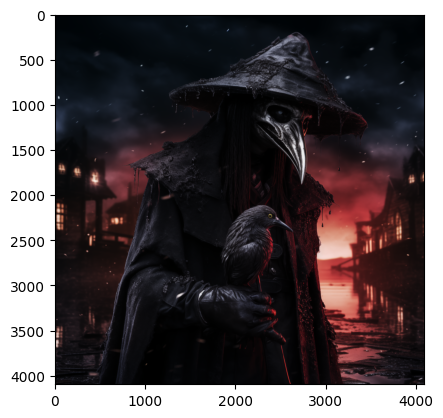

In [5]:
# Resmi okuma ve görüntüleme
# Reading and displaying the image
image = cv2.imread(image_path)

# Resmi RGB formatına dönüştür
# Convert the image to RGB format
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Resmi göster / Display the image
plt.imshow(image)


# **Get the Dimensions of the Image Before Resizing**

We obtain the dimensions of the image before resizing it.

**Resmi Yeniden Boyutlandırmadan Önce Boyutlarını Al**

Resmi yeniden boyutlandırmadan önce boyutlarını alıyoruz.

- `image.shape`: Gets the shape of the image. / Görüntünün şeklini alır.
- `w, h`: Width and height of the image. / Görüntünün genişliği ve yüksekliği.

In [6]:
# Resmi yeniden boyutlandırmadan önce boyutlarını al / Get the dimensions of the image before resizing
w, h, _ = image.shape
w,h

(4096, 4096)

# **Adjust the Image Dimensions to Limit the Pixel Count**
We adjust the image dimensions to limit the pixel count.

# **Piksel Sayısını Sınırlandırmak için Resmin Boyutlarını Ayarla**

Piksel sayısını sınırlandırmak için resmin boyutlarını ayarlıyoruz.

- `for i in range(1, 51)`: Iterates through scale factors. / Ölçek faktörleri arasında iterasyon yapar.
- `new_h, new_w`: New height and width of the image. / Görüntünün yeni yüksekliği ve genişliği.
- `if new_h * new_w < pixelCount`: Checks if the new dimensions are below the pixel count limit. / Yeni boyutların piksel sayısı sınırının altında olup olmadığını kontrol eder.

In [7]:
# Piksel sayısını sınırlandırmak için resmin boyutlarını ayarla / Adjust the image dimensions to limit the pixel count
for i in range(1, 51):
    # Yeni boyutları hesapla / Calculate the new dimensions
    new_h = int(h / i)
    new_w = int(w / i)
    
    # Eğer yeni boyutlar belirli bir piksel sayısından küçükse, boyutları ayarla ve döngüden çık / 
    # If the new dimensions are less than a certain pixel count, set the dimensions and break the loop
    if new_h * new_w < pixelCount:
        h = new_h
        w = new_w
        break
    
    # Eğer döngünün sonuna gelindiyse, boyutları maksimum küçült / If the loop reaches the end, minimize the dimensions
    if i == 50:
        h = int(h / 50)
        w = int(w / 50)

# **Resize, Display, and Save the Image Dimensions**
We resize the image, display it, and save its dimensions.

# **Resmi Yeniden Boyutlandır, Göster ve Boyutları Kaydet**

Resmi yeniden boyutlandırıyor, gösteriyor ve boyutlarını kaydediyoruz.

- `cv2.resize(image, (h, w))`: Resizes the image. / Görüntüyü yeniden boyutlandırır.
- `plt.imshow(image)`: Displays the image. / Görüntüyü gösterir.
- `print(f"Resim boyutu {h}x{w}. Resim {i} kat küçültüldü. Pixel sayısı: {h * w:,}")`: Prints the new image dimensions and pixel count. / Yeni görüntü boyutlarını ve piksel sayısını yazdırır.
- `image.reshape(-1, 3)`: Flattens the image. / Görüntüyü düzleştirir.

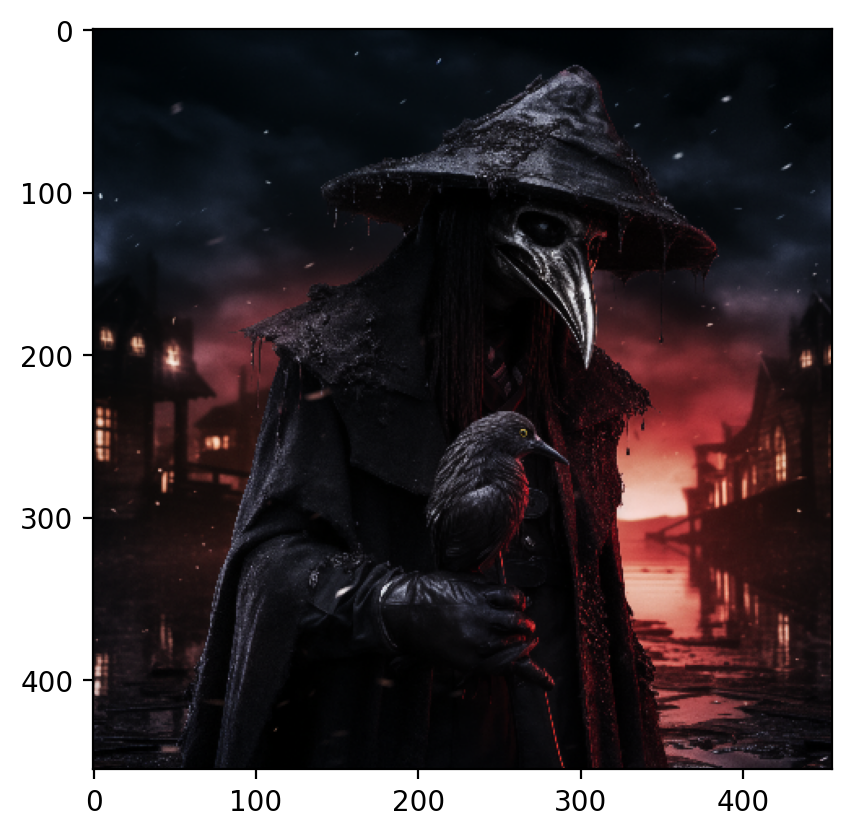

Resim boyutu 455x455. Resim 9 kat küçültüldü. Pixel sayısı: 207,025


In [8]:
# Resmi yeniden boyutlandır / Resize the image
image = cv2.resize(image, (h, w))

# Resmi göster / Display the image
plt.imshow(image)
plt.show()

# Yeni resim boyutlarını ve piksel sayısını yazdır / Print the new image dimensions and pixel count
print(f"Resim boyutu {h}x{w}. Resim {i} kat küçültüldü. Pixel sayısı: {h * w:,}")

# Resmi düzleştir / Flatten the image
pixels = image.reshape(-1, 3)

# Resim boyutlarını kaydet / Save the image dimensions
picture_size = w, h

# **Calculate the Average Processing Time**
We calculate the average processing time for 2000 notes and extrapolate for the entire image.

# **Ortalama İşlem Süresini Hesapla** 

2000 nota için ortalama işlem süresini hesaplar ve tüm görüntü için bu süreyi tahmin ederiz.

- `ort_sure = 3.87 * 1.27`: Calculates the average processing time. / Ortalama işlem süresini hesaplar.
- `print(f'2000 nota count için ortalama dosya süresi {round(ort_sure,1)} saniye. {h*w} pixel için ortalama süre: {round(ort_sure*((h*w)/2000),1)} saniye')`: Prints the average processing time for 2000 notes and extrapolated time for the image. / 2000 nota için ortalama işlem süresini ve görüntü için tahmin edilen süreyi yazdırır.

In [9]:
# Ortalama işlem süresini hesapla / Calculate the average processing time
ort_sure = 3.87 * 1.27  # process işlemi uygulanırsa geçerli yoksa yaklaşık olarak 3 kat artar süre / If the process is applied, this is valid; otherwise, the time increases approximately 3 times

# 2000 nota için ortalama dosya süresini hesapla ve yazdır / Calculate and print the average file time for 2000 notes
print(f'2000 nota count için ortalama dosya süresi {round(ort_sure,1)} saniye. {h*w} pixel için ortalama süre: {round(ort_sure*((h*w)/2000),1)} saniye')

# Explanation
# The code calculates the average time taken to process 2000 notes and then extrapolates that time
# to estimate the total processing time for the entire image based on its pixel count (h * w).
# It assumes that processing each batch of 2000 notes takes approximately 3.87 * 1.27 seconds.


2000 nota count için ortalama dosya süresi 4.9 saniye. 207025 pixel için ortalama süre: 508.8 saniye



# **Extracting Music Notes from Image Pixels**

We define the function `create_music_from_image` to generate music notes from image pixels for each RGB channel.

**Görüntü Piksellerinden Müzik Notalarının Çıkarılması**

Her RGB kanalı için görüntü piksellerinden müzik notaları oluşturmak üzere `create_music_from_image` fonksiyonunu tanımlıyoruz.

- We process pixels in steps of `notaCount`. / Pikselleri `notaCount` adımlarında işleriz.
- For each pixel, we generate corresponding music notes and append them to their respective channels. / Her piksel için ilgili müzik notalarını oluşturur ve bunları ilgili kanallara ekleriz.


In [10]:
def create_music_from_image(notaCount):
    """
    Resmin piksellerinden müzik notaları oluşturur ve her RGB kanalına göre müzik akışları döner.
    Generates music notes from the image pixels and returns music streams for each RGB channel.

    Args:
    notaCount (int): Her adımda işlenecek nota sayısı / Number of notes to process in each step

    Returns:
    tuple: Her RGB kanalı için müzik akışları listesi / Lists of music streams for each RGB channel
    """
    
    # Her RGB kanalı için müzik akışları listeleri başlatılır / Initialize lists for music streams for each RGB channel
    music_stream_R_list, music_stream_G_list, music_stream_B_list = [], [], []
    
    # Piksellerin uzunluğunu hesapla / Calculate the length of pixels
    uzunluk = len(pixels)

    # Her adımda belirli sayıda notayı işle / Process a certain number of notes in each step
    for i in range(0, uzunluk, notaCount):
        # Son adımdaki kalan notaları hesapla / Calculate the remaining notes in the last step
        j = notaCount if i + notaCount <= uzunluk else uzunluk % notaCount
        
        # RGB kanalları için müzik akışları oluştur / Create music streams for RGB channels
        r, g, b = stream.Stream(), stream.Stream(), stream.Stream()

        # Belirli sayıdaki pikseli işle / Process the specified number of pixels
        for pixel_color in pixels[i:i + j]:
            # Her pikselin RGB bileşenlerinden notalar oluştur / Create notes from each pixel's RGB components
            note_obj_R, note_obj_G, note_obj_B = [note.Note(int(c / 3) + 21, quarterLength=0.01) for c in pixel_color]
            
            # Oluşturulan notaları ilgili müzik akışına ekle / Append the created notes to the corresponding music stream
            r.append(note_obj_R)
            g.append(note_obj_G)
            b.append(note_obj_B)
        
        # Oluşturulan müzik akışlarını ilgili listeye ekle / Append the created music streams to the corresponding list
        music_stream_R_list.append(r)
        music_stream_G_list.append(g)
        music_stream_B_list.append(b)
        
    # RGB kanalları için oluşturulan müzik akışlarını döndür / Return the created music streams for RGB channels
    return music_stream_R_list, music_stream_G_list, music_stream_B_list



# **Removing File Paths**

We define the function `remove_file_path` to delete specified files or directories, including their contents.

**Dosya Yollarının Kaldırılması**

Belirtilen dosyaları veya dizinleri içerikleriyle birlikte silmek için `remove_file_path` fonksiyonunu tanımlıyoruz.

- `os.path.exists(file_path)`: Checks if the file path exists. / Dosya yolunun var olup olmadığını kontrol eder.
- `os.path.isdir(file_path)`: Checks if the path is a directory. / Yolun bir dizin olup olmadığını kontrol eder.
- `os.remove(file_path)`: Deletes the file. / Dosyayı siler.
- `os.rmdir(file_path)`: Deletes the directory. / Dizinini siler.


In [11]:
def remove_file_path(file_path):
    """
    Belirtilen dosya veya dizini siler. Dizinse içindeki tüm dosya ve alt dizinleri de siler.
    Removes the specified file or directory. If it's a directory, it removes all files and subdirectories within it.

    Args:
    file_path (str): Silinecek dosya veya dizinin yolu / Path to the file or directory to be deleted
    """
    if os.path.exists(file_path):
        if os.path.isdir(file_path):  # Dizin kontrolü / Directory check
            files = os.listdir(file_path)
            for file in files:
                remove_file_path(os.path.join(file_path, file))  # Alt dosya veya dizini sil / Delete subfile or subdirectory
    else:
        print(f"{file_path} bulunamadı.")  # "{file_path} can't find." / "{file_path} not found."


# **Writing Music to MIDI Files**

We define the function `write_midi` to save a music stream to a MIDI file.

**Müziği MIDI Dosyalarına Yazma**

Bir müzik akışını bir MIDI dosyasına kaydetmek için `write_midi` fonksiyonunu tanımlıyoruz.

- `stream.write('midi', fp=path)`: Writes the music stream to a MIDI file. / Müzik akışını bir MIDI dosyasına yazar.


In [12]:
def write_midi(stream, path, filename, index):
    """
    Verilen müzik akışını belirtilen dosya yoluna MIDI formatında yazar.
    Writes the given music stream to the specified path in MIDI format.

    Args:
    stream (music21.stream.Stream): Yazılacak müzik akışı / Music stream to be written
    path (str): Dosya yolu / Path to the directory where the file will be saved
    filename (str): Dosya adı / Base name of the file
    index (int): Dosya adı için indeks / Index for the file name

    Returns:
    None
    """
    # Dosya yolunu oluştur / Create the file path
    file_path = os.path.join(path, f"{filename}_{index}.mid")
    
    # Müziği MIDI formatında yaz / Write the music in MIDI format
    stream.write('midi', fp=file_path)
    
    # İşlem tamamlandığında bildirim yap / Notify when the process is complete
    print(f"{filename}_{index}.mid dosyası yazıldı.")  # "{filename}_{index}.mid file has been written."



# **Multi-threaded Music File Writing**

We define the function `write_music` to write music streams to MIDI files using multi-threading for efficiency.

**Çok İşlemcili Müzik Dosyası Yazma**

Müzik akışlarını verimli bir şekilde MIDI dosyalarına yazmak için çok işlemcili `write_music` fonksiyonunu tanımlıyoruz.

- `ThreadPoolExecutor`: Manages a pool of threads for concurrent execution. / Eşzamanlı yürütme için bir iş parçacığı havuzunu yönetir.
- `threading.Semaphore`: Controls the number of concurrent threads. / Eşzamanlı iş parçacıklarının sayısını kontrol eder.


In [13]:
def write_music(music_stream, path, filename):
    """
    Verilen müzik akışlarını belirtilen dosya yoluna MIDI formatında yazar. 
    Yazma işlemleri paralel olarak gerçekleştirilir ve her seferinde en fazla 4 iş parçacığı çalışır.
    Writes the given music streams to the specified path in MIDI format.
    The writing operations are performed in parallel with a maximum of 4 threads at a time.

    Args:
    music_stream (list): Yazılacak müzik akışlarının listesi / List of music streams to be written
    path (str): Dosya yolu / Path to the directory where the files will be saved
    filename (str): Dosya adı / Base name of the files

    Returns:
    None
    """
    remove_file_path(path)  # Belirtilen yolu ve içeriğini sil / Remove the specified path and its contents
    
    t = time.time()  # Başlangıç zamanını al / Record the start time
    threads = []  # İş parçacığı listesi / List of threads
    sem = threading.Semaphore(4)  # Aynı anda en fazla 4 iş parçacığının çalışmasını sağla / Semaphore to allow max 4 threads at a time

    def write_midi_thread_wrapper(stream_file, path, filename, c):
        with sem:  # Semaphore'ın düzgün şekilde alınıp bırakıldığından emin ol / Ensure semaphore is acquired and released properly
            write_midi(stream_file, path, filename, c)
            
    for c, stream_file in enumerate(music_stream):  # Her müzik akışı için / For each music stream
        thread = threading.Thread(target=write_midi_thread_wrapper, args=(stream_file, path, filename, c))  # İş parçacığı oluştur / Create a thread
        threads.append(thread)  # İş parçacığını listeye ekle / Append the thread to the list
        thread.start()  # İş parçacığını başlat / Start the thread

    for thread in threads:  # Her iş parçacığı için / For each thread
        thread.join()  # İş parçacığının tamamlanmasını bekle / Wait for the thread to complete

    print("Toplam süre:", round(time.time() - t, 1))  # Toplam süreyi yazdır / Print the total time


# **Creating and Processing Music Streams from the Image**
We create music streams from the image and process them using multi-threading.

# **Resimden Müzik Akışları Oluşturma ve İşleme**

Resimden müzik akışları oluşturuyor ve çoklu iş parçacığı kullanarak işliyoruz.

- `time.time()`: Records the current time. / Geçerli zamanı kaydeder.
- `create_music_from_image(w, h, i, image, notaCount)`: Creates music streams from the image. / Resimden müzik akışları oluşturur.
- `threading.Thread(target=write_music, args=(stream_file, os.path.join(image_RGB_path, col), f"output_{col}))`: Runs the write_music function as a thread. / write_music işlevini iş parçacığı olarak çalıştırır.
- `thread.start()`: Starts the thread. / İş parçacığını başlatır.
- `thread.join()`: Waits for the thread to complete. / İş parçacığının tamamlanmasını bekler.
- `print("Tüm programın çalışması: ", round(time.time() - s, 1), " saniye sürdü")`: Prints the total time taken for the program. / Programın toplam çalışma süresini yazdırır.

In [14]:
s = time.time()  # Başlangıç zamanını al / Record the start time

# Resimden müzik akışları oluştur / Create music streams from the image
music_streams = create_music_from_image(notaCount)

thread_list = []  # İş parçacığı listesi / List of threads

for idx, stream_file in enumerate(music_streams):  # Her müzik akışı için / For each music stream
    col = ["R", "G", "B"][idx]  # R, G ve B kanalları için sütun adı / Column name for R, G, and B channels

    # write_music işlevini iş parçacığı olarak çalıştır / Run the write_music function as a thread
    thread = threading.Thread(target=write_music, args=(stream_file, os.path.join(image_RGB_path, col), f"output_{col}"))
    thread_list.append(thread)  # İş parçacığını listeye ekle / Append the thread to the list
    thread.start()  # İş parçacığını başlat / Start the thread

for thread in thread_list:  # Her iş parçacığı için / For each thread
    thread.join()  # İş parçacığının tamamlanmasını bekle / Wait for the thread to complete

print("Tüm programın çalışması: ", round(time.time() - s, 1), " saniye sürdü")  # Toplam süreyi yazdır / Print the total time


output_G_0.mid dosyası yazıldı.
output_R_1.mid dosyası yazıldı.
output_R_2.mid dosyası yazıldı.
output_G_2.mid dosyası yazıldı.
output_R_3.mid dosyası yazıldı.
output_R_4.mid dosyası yazıldı.output_R_5.mid dosyası yazıldı.
output_B_3.mid dosyası yazıldı.

output_G_5.mid dosyası yazıldı.
output_B_0.mid dosyası yazıldı.
output_G_1.mid dosyası yazıldı.
output_R_0.mid dosyası yazıldı.output_R_6.mid dosyası yazıldı.
output_G_3.mid dosyası yazıldı.

output_B_1.mid dosyası yazıldı.
output_G_7.mid dosyası yazıldı.
output_B_2.mid dosyası yazıldı.
output_G_8.mid dosyası yazıldı.
output_G_4.mid dosyası yazıldı.
output_R_10.mid dosyası yazıldı.
output_G_9.mid dosyası yazıldı.
output_G_11.mid dosyası yazıldı.
output_G_10.mid dosyası yazıldı.
output_G_6.mid dosyası yazıldı.
output_B_4.mid dosyası yazıldı.
output_G_13.mid dosyası yazıldı.
output_B_37.mid dosyası yazıldı.
output_R_7.mid dosyası yazıldı.
output_R_9.mid dosyası yazıldı.
output_G_14.mid dosyası yazıldı.
output_B_43.mid dosyası yazıldı.
o


# **Extracting Numbers from Filenames and Sorting**
We extract numbers from filenames, sort them, and return the last six elements.

# **Dosya Adlarından Numaraları Çıkarma ve Sıralama**

Dosya adlarından numaraları çıkarır, sıralar ve listenin son altı elemanını döndürürüz.

- `extract_number(filename)`: Extracts the number from the filename and returns it as an integer. / Dosya adından numarayı çıkarır ve integer olarak döner.
- `os.listdir()`: Lists directories and files. / Klasörler ve dosyaları listeler.
- `fileNames.append(file)`: Appends the filename to the list. / Dosya adını listeye ekler.
- `fileNames.sort(key=extract_number)`: Sorts the filenames using the custom function. / Dosya adlarını özel fonksiyonla sırala.
- `fileNames[-6:]`: Returns the last six elements of the list. / Listenin son altı elemanını döndürür.

In [37]:
def extract_number(filename):
    """
    Dosya adından numarayı çıkarır ve integer olarak döner.
    Extracts the number from the filename and returns it as an integer.

    Args:
    filename (str): Dosya adı / Filename

    Returns:
    int: Dosya adından çıkarılan numara / Number extracted from the filename
    """
    return int(filename.split('_')[-1].split('.')[0])

# Dosya adlarını tutmak için liste / List to hold filenames
fileNames = []

# Klasörler ve dosyalar arasında dolaş / Iterate through folders and files
for folder in os.listdir("RGB"):
    for file in os.listdir("RGB/" + folder):
        fileNames.append(file)  # Dosya adını listeye ekle / Append the filename to the list

# Dosya adlarını özel fonksiyonla sırala / Sort the filenames using the custom function
fileNames.sort(key=extract_number)

# Listenin son 6 elemanını döndür / Return the last 6 elements of the list
fileNames[-6:]


['output_B_102.mid',
 'output_G_102.mid',
 'output_R_102.mid',
 'output_B_103.mid',
 'output_G_103.mid',
 'output_R_103.mid']

# **Extracting Music Piece from File Path**
We extract the music piece from the file path and return it along with a specified character.

# **Dosya Yolundan Müzik Parçasını Çıkarma**

Dosya yolundan müzik parçasını çıkarır ve belirtilen karakterle birlikte döneriz.

- `os.path.join()`: Creates the file path. / Dosya yolunu oluşturur.
- `converter.parse(file_path)`: Loads the music piece from the file path. / Dosya yolundan müzik parçasını yükler.
- `file[13]`: Gets the 13th character of the filename. / Dosya adının 13. karakterini alır.

In [38]:
def extract_piece(file):
    """
    Dosya yolundan müzik parçasını çıkarır ve belirtilen karakterle birlikte döner.
    Extracts the music piece from the file path and returns it along with a specified character.

    Args:
    file (str): Dosya adı / Filename

    Returns:
    list: Müzik parçası ve dosya adının 13. karakteri / Music piece and the 13th character of the filename
    """
    # Dosya yolunu oluştur / Create the file path
    file_path = os.path.join("RGB", file[7], file)
    
    # Dosya yolundan müzik parçasını yükle / Load the music piece from the file path
    piece = converter.parse(file_path)
    
    # Müzik parçasını ve dosya adının 7. karakterini döndür / Return the music piece and the 7th character of the filename
    return [piece, file[7]]


# **Processing Files and Extracting Music Pieces**
We process the files using ThreadPoolExecutor to extract music pieces and append them to corresponding lists based on their specified character.

# **Dosyaları İşleme ve Müzik Parçalarını Çıkarma**

Dosyaları işlemek için ThreadPoolExecutor kullanarak müzik parçalarını çıkarır ve belirtilen karaktere göre ilgili listelere ekleriz.

- `time.time()`: Records the current time. / Geçerli zamanı kaydeder.
- `ThreadPoolExecutor(max_workers=3)`: Creates a thread pool with a maximum of 3 workers. / Maksimum 3 iş parçacıklı bir iş parçacığı havuzu oluşturur.
- `executor.map(extract_piece, fileNames)`: Maps the extract_piece function to the file names. / extract_piece işlevini dosya adlarına eşler.
- `char_to_list[char].append(piece)`: Appends the music piece to the corresponding list based on the character. / Müzik parçasını karaktere göre ilgili listeye ekler.
- `round(e - s, 1)`: Rounds the total time to one decimal place. / Toplam süreyi bir ondalık basamağa yuvarlar.

In [39]:
# Başlangıç zamanını al / Record the start time
s = time.time()

# Boş listeler oluştur / Create empty lists
piece_R_lis, piece_G_lis, piece_B_lis = [], [], []

# ThreadPoolExecutor kullanarak dosyaları işleyin / Process the files using ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=3) as executor:
    results = executor.map(extract_piece, fileNames)

# Sonuçları ilgili listelere ekleyin / Append the results to the corresponding lists
char_to_list = {'R': piece_R_lis, 'G': piece_G_lis, 'B': piece_B_lis}

for piece, char in results:
    char_to_list[char].append(piece)

# Bitiş zamanını al / Record the end time
e = time.time()

# Toplam süreyi yazdır / Print the total time
print("Total time to parse files:", round(e - s, 1))

Total time to parse files: 43.0


# **Get and Print the First 10 Elements**
We retrieve and print the first 10 elements from the list of music pieces corresponding to the 'R' channel.

# **İlk 10 Öğeyi Al ve Yazdır**

'R' kanalına karşılık gelen müzik parçaları listesinden ilk 10 öğeyi alır ve yazdırırız.

- `piece_R_lis[:10]`: Gets the first 10 elements from the list. / Listenin ilk 10 öğesini alır.
- `print(piece)`: Prints each music piece. / Her bir müzik parçasını yazdırır.

In [40]:
# İlk 10 öğeyi al ve yazdır / Get and print the first 10 elements
first_10_pieces_R = piece_R_lis[:10]

# İlk 10 öğeyi yazdır / Print the first 10 elements
for piece in first_10_pieces_R:
    print(piece)

<music21.stream.Score 0x1d5876a4640>
<music21.stream.Score 0x1d60a88ec70>
<music21.stream.Score 0x1d60756b5b0>
<music21.stream.Score 0x1d604e681c0>
<music21.stream.Score 0x1d62711d4f0>
<music21.stream.Score 0x1d58a76f880>
<music21.stream.Score 0x1d6690cb2b0>
<music21.stream.Score 0x1d645e742e0>
<music21.stream.Score 0x1d632d1fc10>
<music21.stream.Score 0x1d69826aaf0>


# **Extract Notes and Append to Corresponding Lists**
We extract notes from the music pieces and append them to the corresponding lists for 'R', 'G', and 'B' channels. Then, we print the first 10 notes from the 'R' channel list.

# **Notaları Ayıkla ve İlgili Listelere Ekle**

Müzik parçalarından notaları çıkarır ve 'R', 'G' ve 'B' kanalları için ilgili listelere ekleriz. Ardından, 'R' kanalındaki notalar listesinden ilk 10 notayı yazdırırız.

- `piece.flat.notes`: Extracts notes from a music piece. / Bir müzik parçasından notaları ayıklar.
- `notes_list.extend()`: Appends the extracted notes to the corresponding list. / Çıkarılan notaları ilgili listeye ekler.
- `print(notes_R[:10])`: Prints the first 10 notes from the 'R' channel list. / 'R' kanalındaki notalar listesinden ilk 10 notayı yazdırır.

In [41]:
# Notes lists / Not listeleri
notes_R, notes_G, notes_B = [], [], []

# Notları ayıkla ve ilgili listelere ekle / Extract notes and append to corresponding lists
for pieces, notes_list in zip([piece_R_lis, piece_G_lis, piece_B_lis], [notes_R, notes_G, notes_B]):
    notes_list.extend(piece.flat.notes for piece in pieces)

# İlk 10 öğeyi yazdır / Print the first 10 elements
print(notes_R[:10])

[<music21.stream.iterator.StreamIterator for Score:0x1d6980311f0 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d6980312b0 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031970 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031c10 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031d00 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031f40 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031f10 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031e20 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d698031520 @:0>, <music21.stream.iterator.StreamIterator for Score:0x1d696ae5be0 @:0>]


# **Convert Note Object to MIDI Note Number**
We convert a note object to a MIDI note number.

# **Nota Objesini MIDI Nota Numarasına Dönüştür**

Bir nota objesini MIDI nota numarasına dönüştürürüz.

- `note.pitch.octave`: Gets the octave of the note. / Notanın oktavını alır.
- `note.pitch.pitchClass`: Gets the pitch class of the note. / Notanın ses sınıfını alır.
- `return (note.pitch.octave + 1) * 12 + note.pitch.pitchClass`: Calculates the MIDI note number. / MIDI nota numarasını hesaplar.

In [42]:
def note_to_number(note):
    """
    Nota objesini MIDI nota numarasına dönüştürür.
    Converts a note object to a MIDI note number.

    Args:
    note (music21.note.Note): Dönüştürülecek nota objesi / Note object to be converted

    Returns:
    int: MIDI nota numarası / MIDI note number
    """
    # MIDI nota numarasını hesapla / Calculate the MIDI note number
    return (note.pitch.octave + 1) * 12 + note.pitch.pitchClass


# **Convert Notes to Pixels**
We convert a list of notes to pixels and return the result as a list.

# **Notaları Piksellere Dönüştürme**

Bir nota listesini piksellere dönüştürür ve sonucu bir liste olarak döneriz.

- `note_to_number(not_Alp)`: Converts a note object to a MIDI note number. / Nota objesini MIDI nota numarasına dönüştürür.
- `min((note_to_number(not_Alp)-21) * 3 , 255)`: Scales the MIDI note number to a pixel value, limiting the maximum value to 255. / MIDI nota numarasını bir piksel değerine ölçeklendirir ve maksimum değeri 255 ile sınırlar.
- `pixelList.append(note_number)`: Appends the calculated pixel value to the list. / Hesaplanan piksel değerini listeye ekler.

In [43]:
def solve(notes):
    """
    Notları piksellere dönüştürür ve bir liste olarak döner.
    Converts notes to pixels and returns as a list.

    Args:
    notes (list): Nota listesi / List of notes

    Returns:
    list: Piksel listesi / List of pixels
    """
    pixelList = []
    
    for note in notes:
        for not_Alp in note:
            # MIDI notaları 21 ile 108 arasında olduğu için, hesaplama ve sınırlandırma / 
            # Since MIDI notes are between 21 and 108, calculate and limit
            note_number = min((note_to_number(not_Alp)-21) * 3 , 255)  
            pixelList.append(note_number)
            
    return pixelList


# **Process Notes Lists and Convert to Pixels**
We initialize lists for R, G, and B channels, process the notes lists, convert them to pixels, and print the length of each list.

# **Notes Listelerini İşleyin ve Piksellere Dönüştürün**

R, G ve B kanalları için listeleri başlatır, notalar listesini işler, piksellere dönüştürür ve her listenin uzunluğunu yazdırırız.

- `solve(note)`: Converts a note to a list of pixel values. / Bir notayı piksel değerleri listesine dönüştürür.
- `color_list.extend()`: Appends the converted pixel values to the corresponding list. / Dönüştürülen piksel değerlerini ilgili listeye ekler.
- `len(r_list), len(g_list), len(b_list)`: Prints the length of each list. / Her listenin uzunluğunu yazdırır.

In [44]:
# R, G, B listelerini başlat / Initialize R, G, B lists
r_list, g_list, b_list = [], [], []

# Notes listelerini işleyin ve piksellere dönüştürün / Process notes lists and convert to pixels
for notes, color_list in zip([notes_R, notes_G, notes_B], [r_list, g_list, b_list]):
    color_list.extend(solve(note) for note in notes)

# Her listenin uzunluğunu yazdır / Print the length of each list
len(r_list), len(g_list), len(b_list)


(104, 104, 104)


# **Creating and Displaying an Image from Note Data**

We merge notes from the RGB channels into a new image and display it.

**Nota Verilerinden Görüntü Oluşturma ve Gösterme**

RGB kanallarından notaları yeni bir görüntüye birleştiriyor ve gösteriyoruz.

- `list_merge(liste)`: Merges sub-lists into a single list. / Alt listeleri tek bir listeye birleştirir.
- `Image.fromarray(array_RGB)`: Creates an image from a numpy array. / Bir numpy dizisinden görüntü oluşturur.
- `plt.imshow(image)`: Displays the image. / Görüntüyü gösterir.


In [45]:
def list_merge(liste):
    """
    Alt listeleri tek bir listeye birleştirir.
    Merges sub-lists into a single list.

    Args:
    liste (list of lists): Birleştirilecek alt listeler / Sub-lists to be merged

    Returns:
    list: Birleştirilmiş liste / Merged list
    """
    return [item for sub_list in liste for item in sub_list]


In [46]:
# R, G, B listelerini birleştir / Merge the R, G, B lists
r_listMulti = list_merge(r_list)
g_listMulti = list_merge(g_list)
b_listMulti = list_merge(b_list)

# Birleştirilmiş listelerin uzunluklarını yazdır / Print the lengths of the merged lists
len(r_listMulti), len(g_listMulti), len(b_listMulti)

(207025, 207025, 207025)

In [47]:
new = []  # Yeni listeyi başlat / Initialize a new list
temp = []  # Geçici listeyi başlat / Initialize a temporary list

# R, G, B listelerindeki her öğe için döngü / Loop through each element in the R, G, B lists
for i in range(len(r_listMulti)):
    # R, G, B değerlerini tek bir listeye ekle / Append the R, G, B values into a single list
    temp.append([r_listMulti[i], g_listMulti[i], b_listMulti[i]])
    
    # Geçici listeyi yeni listeye ekle ve geçici listeyi temizle / Append the temporary list to the new list and reset the temporary list
    if (i + 1) % picture_size[0] == 0:
        new.append(temp)
        temp = []

# Sonuçları bir numpy dizisine dönüştür / Convert the results into a numpy array
array_RGB = np.array(new, dtype=np.uint8)


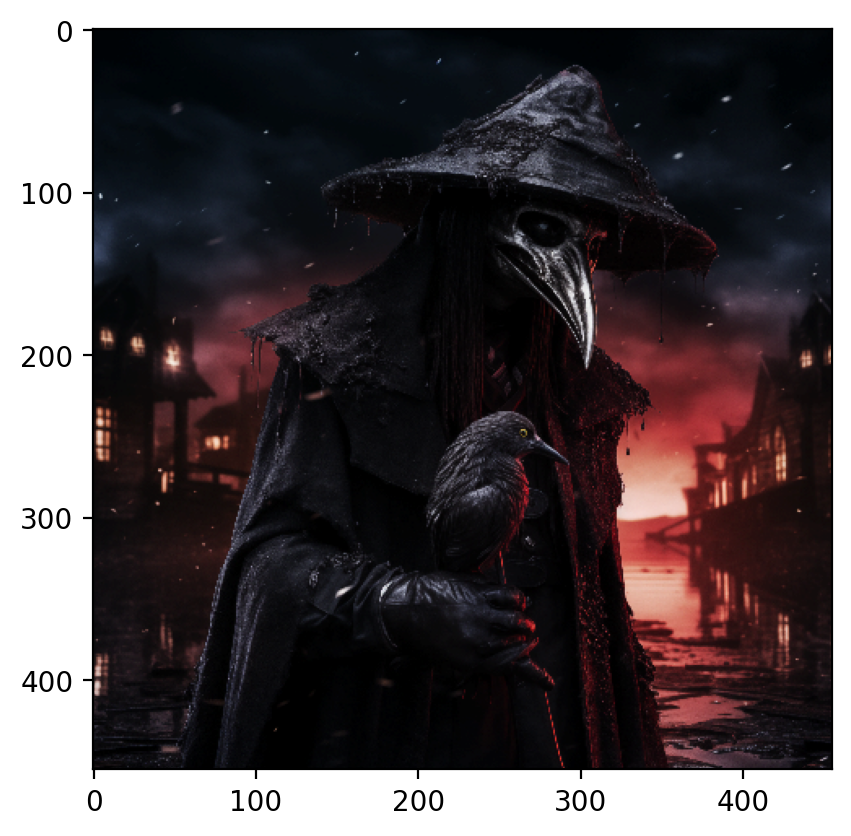

In [48]:
# Numpy dizisinden yeni bir görüntü oluştur / Create a new image from the numpy array
new_image = Image.fromarray(array_RGB)

# Yeni görüntüyü göster / Display the new image
plt.imshow(new_image)
plt.show()

# **Save Processed Image with Unique File Name**
We record the start time, create the output directory, determine the dimensions of the image, list files in the output directory, determine the new file name, save the image, and print the running time.

# **İşlenmiş Görüntüyü Benzersiz Dosya Adı ile Kaydet**

Başlangıç zamanını kaydeder, çıktı dizinini oluşturur, resmin boyutlarını belirler, çıktı dizinindeki dosyaları listeler, yeni dosya adını belirler, görüntüyü kaydeder ve çalışma süresini yazdırırız.

- `os.makedirs(image_output_path, exist_ok=True)`: Creates the output directory if it doesn't exist. / Çıktı dizinini yoksa oluşturur.
- `os.listdir(image_output_path)`: Lists files in the output directory. / Çıktı dizinindeki dosyaları listeler.
- `liste.sort()`: Sorts the list of files. / Dosya listesini sıralar.
- `new_image.save(save_path)`: Saves the image to the specified path. / Görüntüyü belirtilen yola kaydeder.
- `time.time()`: Records the current time. / Geçerli zamanı kaydeder.
- `round(e - s, 1)`: Rounds the running time to one decimal place. / Çalışma süresini bir ondalık basamağa yuvarlar.

In [49]:
# Başlangıç zamanını al / Record the start time
s = time.time()

# Çıktı dizinini oluştur / Create the output directory
os.makedirs(image_output_path, exist_ok=True)

# Resmin boyutlarını belirle / Determine the dimensions of the image
dimensions = f"{picture_size[0]}x{picture_size[1]}"

# Çıktı dizinindeki dosyaları listele / List files in the output directory
liste = os.listdir(image_output_path)

# Yeni dosya adını belirle ve kaydet / Determine the new file name and save the image
if len(liste) == 0:
    # Çıktı dizininde dosya yoksa / If no files in the output directory
    new_file_name = f"output_0_{dimensions}.png"
else:
    # Çıktı dizininde dosya varsa / If there are files in the output directory
    liste.sort()
    last_file = liste[-1]
    last_file_num = last_file.split("_")[1]
    new_file_name = f"output_{int(last_file_num) + 1}_{dimensions}.png"

save_path = os.path.join(image_output_path, new_file_name)
new_image.save(save_path)

# Bitiş zamanını al ve çalışma süresini yazdır / Record the end time and print the running time
e = time.time()
print("Program running time:", round(e - s, 1))

Program running time: 0.1


# **List Files in the Output Directory and Get the Last File Name**
We list files in the output directory, print a message if no files are found, otherwise get and print the last file name.

# **Çıktı Dizinindeki Dosyaları Listele ve Son Dosya Adını Al**

Çıktı dizinindeki dosyaları listeler, dosya yoksa mesaj yazdırır, aksi takdirde son dosya adını alır ve yazdırırız.

- `os.listdir(image_output_path)`: Lists files in the output directory. / Çıktı dizinindeki dosyaları listeler.
- `len(liste) == 0`: Checks if the list of files is empty. / Dosya listesinin boş olup olmadığını kontrol eder.
- `liste.sort()`: Sorts the list of files. / Dosya listesini sıralar.
- `liste[-1]`: Gets the last file name from the sorted list. / Sıralanan listenin son dosya adını alır.
- `print(imageName)`: Prints the last file name. / Son dosya adını yazdırır.

In [50]:
# Çıktı dizinindeki dosyaları listele / List files in the output directory
liste = os.listdir(image_output_path)

# Dosya yoksa mesaj yazdır, varsa son dosya adını al / Print a message if no files, otherwise get the last file name
if len(liste) == 0:
    print("Resim yok")  # No image
else:
    liste.sort()
    imageName = liste[-1]

# Son dosya adını yazdır / Print the last file name
imageName

'output_1_455x455.png'


# **Upscaling and Saving Images Using LAPSRN and Bicubic Interpolation**

We upscale images using the LAPSRN model and bicubic interpolation, then save and display the results.

**LAPSRN ve Bikübik Enterpolasyon Kullanarak Görüntülerin Ölçeklendirilmesi ve Kaydedilmesi**

LAPSRN modeli ve bikübik enterpolasyon kullanarak görüntüleri ölçeklendiriyor, ardından sonuçları kaydediyor ve gösteriyoruz.

- `dnn_superres.DnnSuperResImpl_create()`: Creates a super-resolution model. / Bir süper çözünürlük modeli oluşturur.
- `sr.readModel(path)`: Loads the pre-trained model. / Önceden eğitilmiş modeli yükler.
- `sr.setModel("lapsrn", scale)`: Sets the model type and scale factor. / Model türünü ve ölçek faktörünü ayarlar.
- `sr.upsample(image)`: Uses the LAPSRN model to upscale the image. / Görüntüyü ölçeklendirmek için LAPSRN modelini kullanır.
- `cv2.resize(image, interpolation=cv2.INTER_CUBIC)`: Uses bicubic interpolation to upscale the image. / Görüntüyü ölçeklendirmek için bikübik enterpolasyonu kullanır.
- `cv2.imwrite(path, image)`: Saves the upscaled image to the specified path. / Ölçeklendirilmiş görüntüyü belirtilen yola kaydeder.
- `plt.imshow(image)`: Displays the upscaled image. / Ölçeklendirilmiş görüntüyü gösterir.

In [51]:
# LAPSRN modelini yükle ve ayarla / Load and configure the LAPSRN model

# Süper çözünürlük modelini oluştur / Create the super-resolution model
sr = cv2.dnn_superres.DnnSuperResImpl_create()

# Model dosyasının yolu / Path to the model file
path = 'model/LapSRN_x8.pb'

# Modeli oku / Read the model
sr.readModel(path)

# Modeli ve ölçek faktörünü ayarla / Set the model and scale factor
sr.setModel('lapsrn', 8)

# CUDA kullanarak işlemeyi tercih et / Prefer processing using CUDA
sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

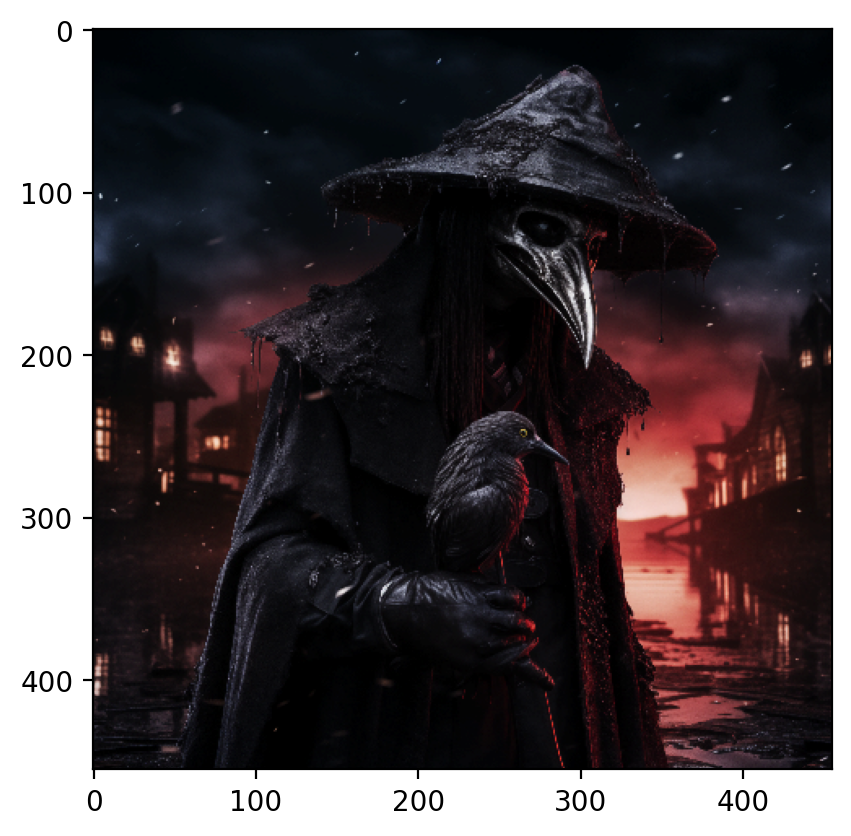

In [52]:
# Resmi oku ve göster / Read and display the image

# Çıktı dizininden resmi oku / Read the image from the output directory
image = cv2.imread(os.path.join("output", imageName))

# Resmi doğru renk formatında göster / Display the image in the correct color format
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

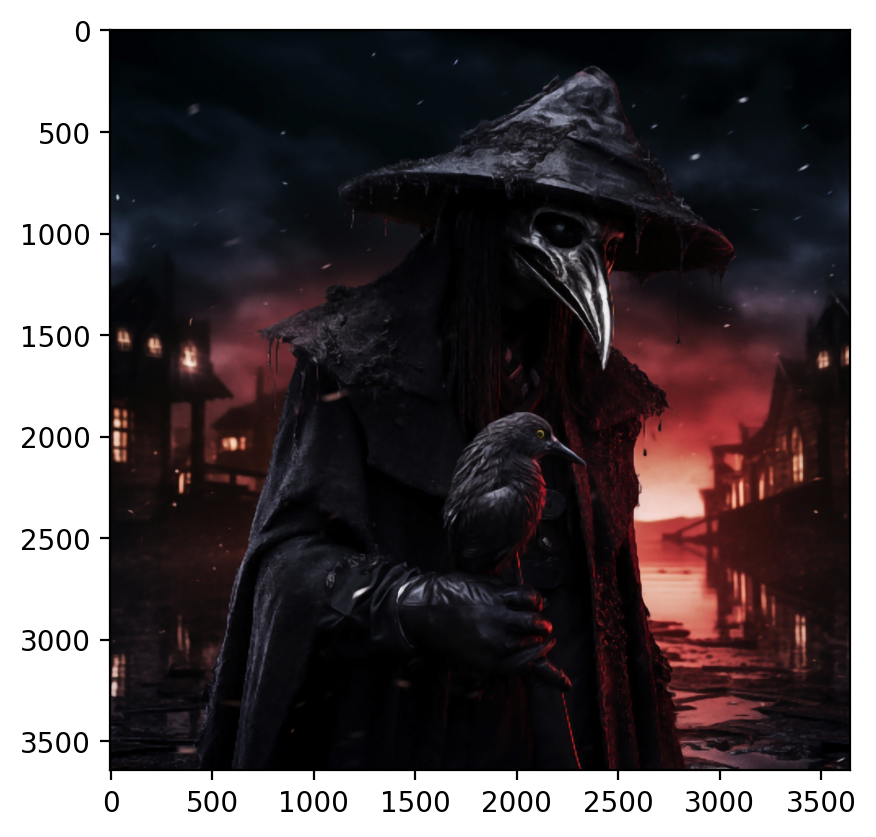

In [53]:
# LapSRN modelini kullanarak resmi ölçeklendir ve göster / Upscale and display the image using the LapSRN model

# Resmi ölçeklendir / Upscale the image
upscaled = sr.upsample(image)

# Ölçeklendirilmiş resmi kaydet / Save the upscaled image
cv2.imwrite(os.path.join("upscale", f"{imageName}_upscaled_test_lapsrn.png"), upscaled)

# Ölçeklendirilmiş resmi doğru renk formatında göster / Display the upscaled image in the correct color format
plt.imshow(cv2.cvtColor(upscaled, cv2.COLOR_BGR2RGB))
plt.show()

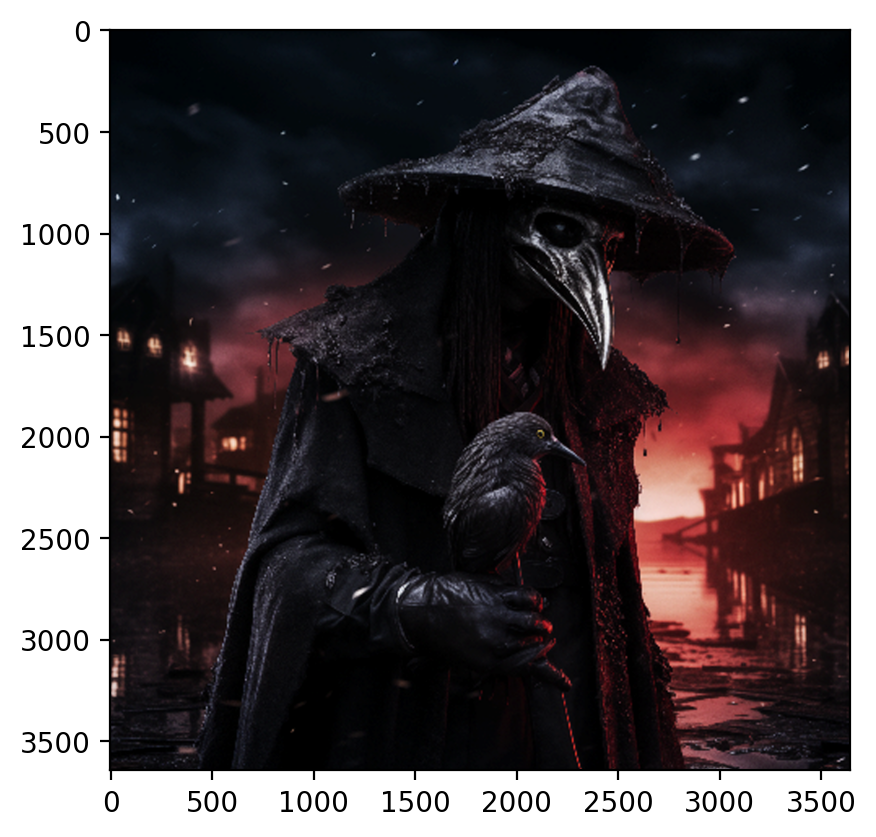

In [54]:
# Bicubic interpolation kullanarak resmi ölçeklendir ve göster / Upscale and display the image using bicubic interpolation

# Bicubic interpolation kullanarak resmi ölçeklendir / Upscale the image using bicubic interpolation
bicubic = cv2.resize(image, (upscaled.shape[1], upscaled.shape[0]), interpolation=cv2.INTER_CUBIC)

# Bicubic ölçeklendirilmiş resmi kaydet / Save the bicubic upscaled image
cv2.imwrite(os.path.join("upscale", f"{imageName}_bicubic_test_8x.png"), bicubic)

# Bicubic ölçeklendirilmiş resmi doğru renk formatında göster / Display the bicubic upscaled image in the correct color format
plt.imshow(cv2.cvtColor(bicubic, cv2.COLOR_BGR2RGB))